In [1]:
import numpy as np

def NbodyInit_Plummer(num_bodies):
    x0 = np.zeros((num_bodies, 3), dtype=float)
    v0 = np.zeros((num_bodies, 3), dtype=float)
    m = np.ones((num_bodies), dtype=float)*1.0
    for i in range(num_bodies):
        x = np.zeros(3,dtype=float)
        v = np.zeros(3,dtype=float)
        RI = (np.random.random()**(-2/3) - 1.0)**(-0.5)
        # Reject distant particles
        while RI > 10.0:
            RI = (np.random.random()**(-2/3) - 1.0)**(-0.5)

        txa = np.random.uniform(0, 2.0*np.pi)
        x[2] = np.random.uniform(-1,1) * RI
        x[0] = np.sqrt(RI**2 - x[2]**2) * np.cos(txa)
        x[1] = np.sqrt(RI**2 - x[2]**2) * np.sin(txa)

        tv0 = np.random.random()
        tv1 = np.random.random()
        tv2 = tv0**2 * (1.0 - tv0**2)**3.5
        while (0.1*tv1 > tv2):
            tv0 = np.random.random()
            tv1 = np.random.random()
            tv2 = tv0**2 * (1.0 - tv0**2)**3.5
        
        tvr = tv0 * np.sqrt(2.0) / (1.0 + RI**2)**0.25
        tva = np.random.uniform(0, 2.0*np.pi)
        v[2] = np.random.uniform(-1,1) * tvr
        v[0] = np.sqrt(tvr**2 - v[2]**2) * np.cos(tva)
        v[1] = np.sqrt(tvr**2 - v[2]**2) * np.sin(tva)
        x0[i] = np.copy(x)
        v0[i] = np.copy(v)
    mf = np.sum(m)
    xf = 3.0*np.pi/16.0
    vf = np.sqrt(mf/xf)*0.6
    cmx = np.mean(x0*np.stack((m,m,m), axis=1), axis=0)
    cmv = np.mean(v0*np.stack((m,m,m), axis=1), axis=0)
    x0 = xf*(x0 - (cmx/mf))
    v0 = vf*(v0 - (cmv/mf))
    return [x0, v0, m]

def NbodyInit_Uniform(num_bodies):
    x0 = np.zeros((num_bodies, 3), dtype=float)
    v0 = np.zeros((num_bodies, 3), dtype=float)
    m = np.ones((num_bodies), dtype=float)*1.0
    for i in range(num_bodies):
        x = np.random.uniform(-1.0,1.0,3)
        while np.sum(x*x) > 1.0:
            x = np.random.uniform(-1.0,1.0,3)
        v = np.random.uniform(-1.0,1.0,3)
        while np.sum(v*v) > 1.0:
            v = np.random.uniform(-1.0,1.0,3)
        x0[i] = np.copy(x)
        v0[i] = np.copy(v)
    mf = np.sum(m)
    xf = 3.0*np.pi/16.0
    vf = np.sqrt(mf/xf)*0.6
    cmx = np.mean(x0*np.stack((m,m,m), axis=1), axis=0)
    cmv = np.mean(v0*np.stack((m,m,m), axis=1), axis=0)
    x0 = xf*(x0 - (cmx/mf))
    v0 = vf*(v0 - (cmv/mf))
    return [x0, v0, m]


In [2]:
G = 1
epsilon = 1e-5   # Softening parameter to avoid singularities
def NBody_rescale(x0, v0, m):
    W = 0.0
    K = 0.0
    N = x0.shape[0]
    for i in range(0, N):
        for j in range(0, N):
            if (i == j):
                continue
            r = x0[j] - x0[i]
            Wij = G*m[i]*m[j] / np.sqrt(np.sum(r**2) + epsilon**2)
            W += Wij
        Ki = m[i]*np.sum(v0[i] ** 2)
        K += Ki
    print(W, K)
    return [x0, v0/np.sqrt(K/(W/2)), m]

In [3]:
class Nbody:
    def __init__(self, x0a, v0a, ma):
        self.num_bodies = x0a.shape[0]
        self.x0 = np.copy(x0a)
        self.v0 = np.copy(v0a)
        self.m = np.copy(ma)

    def sforce(self, x0, i, j):
        G = 1  # Gravitational constant
        #G = 4.5185e-48  # Gravitational constant
        epsilon = 1e-5   # Softening parameter to avoid singularities
        r = x0[j]-x0[i] 
        d2 = np.sum(r**2) + epsilon**2
        return r * G / (d2**(3/2))

    def accel(self, x0):
        a0 = np.zeros((num_bodies, 3), dtype=float)
        for i in range(self.num_bodies):
            for j in range(i+1, self.num_bodies):
                sfij = self.sforce(x0, i, j)
                a0[i] += sfij * self.m[j]
                a0[j] -= sfij * self.m[i]
        return a0

    def pivot(self, xx, vv, m):
        rx = vv
        rv = self.accel(xx)
        return [rx, rv]

    def timestep(self, dt):
        x1k, v1k = self.pivot(self.x0, self.v0, self.m)
        x2k, v2k = self.pivot(self.x0 + x1k*dt/2.0, self.v0 + v1k*dt/2.0, self.m)
        x3k, v3k = self.pivot(self.x0 + x2k*dt/2.0, self.v0 + v2k*dt/2.0, self.m)
        x4k, v4k = self.pivot(self.x0 + x3k*dt, self.v0 + v3k*dt, self.m)
        self.x0 += dt*(x1k + x2k*2.0 + x3k*2.0 + x4k)/6.0
        self.v0 += dt*(v1k + v2k*2.0 + v3k*2.0 + v4k)/6.0
        mf = np.sum(self.m)
        cmx = np.mean(self.x0*np.stack((self.m,self.m,self.m), axis=1), axis=0)/mf
        self.x0 -= cmx

    def timestep_E(self, dt):
        a0 = self.accel(self.x0)
        self.x0 += self.v0*dt
        self.v0 += a0*dt


In [4]:
num_bodies = 10
xi, vi, mi = NbodyInit_Plummer(num_bodies)
xs, vs, ms = NBody_rescale(xi, vi, mi)

NbodySystem = Nbody(xs, vs, ms)

75.05234225891849 20.93913672280982


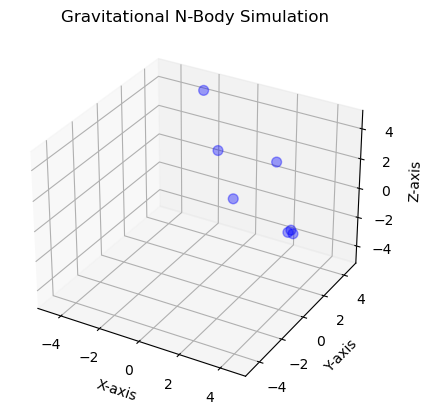

In [5]:
time_steps = 70
dt = 0.001


%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
#plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 150  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_xlim3d([-5,5])
ax.set_ylim3d([-5,5])
ax.set_zlim3d([-5,5])
ax.set_title('Gravitational N-Body Simulation')

pt = ax.scatter(0, 0, 0, color='blue', s=50, edgecolors=None, zorder=10)

def simulation(nb, time_steps, dt):
    for _ in range(time_steps):
        nb.timestep(dt)

def animate(i):
    simulation(NbodySystem, time_steps, dt)
    pt.set_offsets(NbodySystem.x0[:,:2])
    pt.set_3d_properties(NbodySystem.x0[:,2], zdir='z')
    return [pt]

ani = FuncAnimation(fig, animate, frames=100)
ani